In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import eda_helper_functions

## Read the Training data

In [11]:
file_path=r"C:\Users\arpit\Desktop\Flight SageMaker\data\train.csv"
train=pd.read_csv(file_path)

In [12]:
train.dtypes

airline             object
date_of_journey     object
source              object
destination         object
dep_time            object
arrival_time        object
duration             int64
total_stops        float64
additional_info     object
price                int64
dtype: object

In [24]:
train=train.assign(**{
       col:pd.to_datetime(train.loc[:,col])
       for col in ['date_of_journey','dep_time','arrival_time']
   })
train.dtypes

airline                    object
date_of_journey    datetime64[ns]
source                     object
destination                object
dep_time           datetime64[ns]
arrival_time       datetime64[ns]
duration                    int64
total_stops               float64
additional_info            object
price                       int64
dtype: object

## High Level Summary Data

In [27]:
train.describe(include='number')

,duration,total_stops,price
count,8369.000000,8368.000000,8369.000000
mean,630.953519,0.804971,9058.268132
std,499.388080,0.660819,4655.727895
min,75.000000,0.000000,1759.000000
25%,170.000000,0.000000,5224.000000
50%,505.000000,1.000000,8355.000000
75%,920.000000,1.000000,12373.000000
max,2860.000000,3.000000,79512.000000


In [35]:
(

  train
  .assign(total_stops=train['total_stops'].astype('O'))
  .describe(include='O')
    
)

,airline,source,destination,total_stops,additional_info
count,8369,8369,8369,8368.0,8369
unique,9,5,6,4.0,10
top,Jet Airways,Delhi,Cochin,1.0,No info
freq,2991,3452,3452,4483.0,6562


## High Level Analysis of Missing Values

In [57]:
def missing_info(df):
    na_cols=[col for col in df.columns if df[col].isna().any()]
    count_cols=[df[col].isna().sum() for col in na_cols]
    perc_cols=[ (df[col].isna().mean()*100) for col in na_cols]
    
    return pd.DataFrame(
        {
            'variable':na_cols,
            'count':count_cols,
            'mean':perc_cols
        }
    ).sort_values(by='count',ascending=False).set_index('variable')

In [58]:
missing_info(train)

,count,mean
variable,,
total_stops,1,0.011949


In [72]:
def plot_missing_data_info(df, bar_label_params=None, figsize=(10,4)):
    na_data=missing_info(df)
    fig,ax=plt.subplots(1,1,figsize=figsize)
    bar=ax.bar(
        range(len(na_data)),
        height=na_data['count'].values,
        color='blue',
        edgecolor='black',
        tick_label=na_data.index.tolist(),
        alpha=0.7
        )
    if bar_label_params is not None:
        ax.bar_label(
            bar,
            **bar_label_params
        )
    
    ax.set(
        xlabel='Variable',
        ylabel='Count',
        title='Missing data Count vs variable'
    )
    
    #rotate_labels(ax)
    plt.tight_layout()
    plt.show()


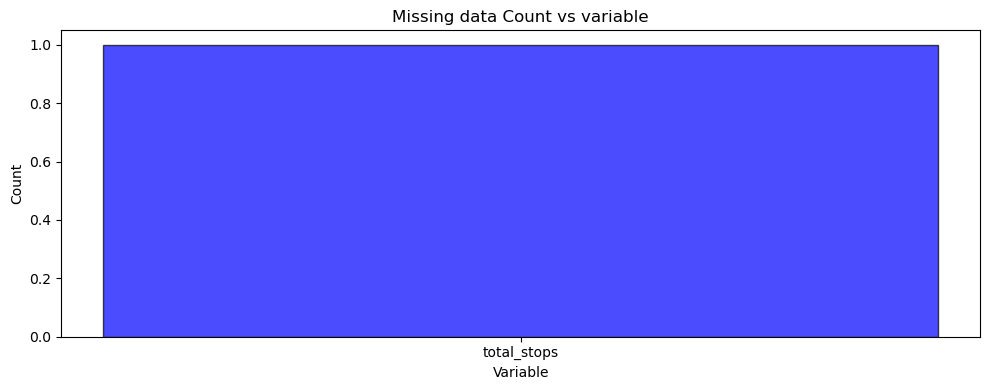

In [73]:
plot_missing_data_info(train)

In [84]:
train=train[~train['total_stops'].isna()]

In [125]:
train=(train
 .assign(total_stops=train.total_stops.astype('O')
 )
)

In [127]:
train.total_stops.unique()

array([0, 1, 2, 3], dtype=object)

In [126]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8368 entries, 0 to 8368
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   airline          8368 non-null   object        
 1   date_of_journey  8368 non-null   datetime64[ns]
 2   source           8368 non-null   object        
 3   destination      8368 non-null   object        
 4   dep_time         8368 non-null   datetime64[ns]
 5   arrival_time     8368 non-null   datetime64[ns]
 6   duration         8368 non-null   int64         
 7   total_stops      8368 non-null   object        
 8   additional_info  8368 non-null   object        
 9   price            8368 non-null   int64         
dtypes: datetime64[ns](3), int64(2), object(5)
memory usage: 719.1+ KB


## High Level Analysis of Outliers

In [128]:
from sklearn.ensemble import IsolationForest
forest=IsolationForest(n_estimators=10,random_state=42)


In [129]:
(train
   .drop(columns="price")
   .select_dtypes(include="number")
)

,duration
0,195
1,540
2,90
3,290
4,1215
...,...
8364,170
8365,860
8366,300
8367,195


In [133]:
(
    train
   .assign(outlier=forest.fit_predict(
    train
   .drop(columns="price")
   .select_dtypes(include="number")
   ))
   .query("outlier == -1")
   .duration
   .describe()
)

count    3611.000000
mean      928.816117
std       585.961001
min        75.000000
25%       290.000000
50%      1005.000000
75%      1420.000000
max      2860.000000
Name: duration, dtype: float64

## Heatmap

In [156]:
# correlation matrix heatmap
def correlation_heatmap(data,
                        figsize=(12, 6),
                        method="spearman",
                        cmap="RdBu"):
  cm = data.corr(method=method)#, numeric_only=True)

  mask = np.zeros_like(cm, dtype=bool)
  mask[np.triu_indices_from(mask)] = True

  fig, ax = plt.subplots(figsize=figsize)
  hm = sns.heatmap(
      cm,
      vmin=-1,
      vmax=1,
      cmap=cmap,
      center=0,
      annot=True,
      fmt=".2f",
      linewidths=1.5,
      square=True,
      mask=mask,
      ax=ax
  )

  #rotate_xlabels(ax)
  #rotate_ylabels(ax)
  ax.set(title=f"{method.title()} Correlation Matrix Heatmap")


C:\Users\arpit\anaconda3\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


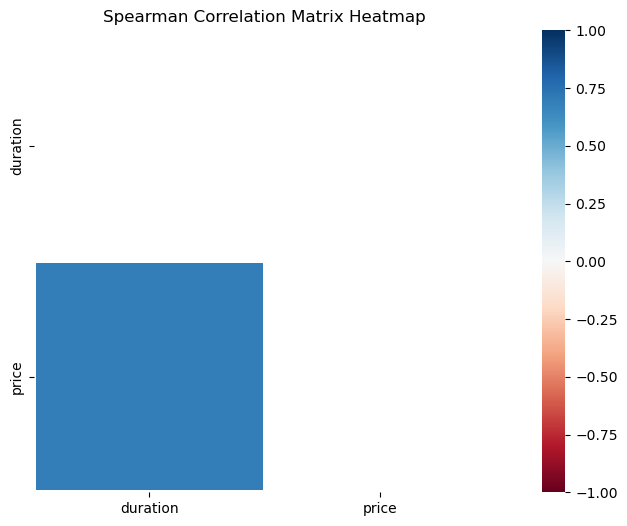

In [157]:
correlation_heatmap(train)

## Detailed Analysis

In [158]:
train.columns

Index(['airline', 'date_of_journey', 'source', 'destination', 'dep_time',
       'arrival_time', 'duration', 'total_stops', 'additional_info', 'price'],
      dtype='object')

## airline



In [159]:
train.airline

0            Indigo
1       Jet Airways
2          Spicejet
3            Indigo
4         Air India
           ...     
8364         Indigo
8365    Jet Airways
8366         Indigo
8367         Indigo
8368    Jet Airways
Name: airline, Length: 8368, dtype: object

In [233]:
def cat_summary(data,column):
    print(data[column])
    print('Meta Data')
    print(f'DataType:{data[column].dtype}')
    print(f'Cardinality:{data[column].nunique()}')
    print(f'Missing Data:{data[column].isna().sum()}')
    total_count=data[column].count()
    print(f'Available Data:{total_count}')
    print(f'Summary :')
    print(data[column].describe())
    print('\n')
    print(f'Categories Distribution')
    df=pd.DataFrame(data[column].value_counts().reset_index().rename(columns={column:'count','index':'category'}))
    df['percentage']=data[column].value_counts(normalize=True).values
    print(df)
    

In [234]:
(cat_summary(train,'airline'))

0            Indigo
1       Jet Airways
2          Spicejet
3            Indigo
4         Air India
           ...     
8364         Indigo
8365    Jet Airways
8366         Indigo
8367         Indigo
8368    Jet Airways
Name: airline, Length: 8368, dtype: object
Meta Data
DataType:object
Cardinality:9
Missing Data:0
Available Data:8368
Summary :
count            8368
unique              9
top       Jet Airways
freq             2991
Name: airline, dtype: object


Categories Distribution
            category  count  percentage
0        Jet Airways   2991    0.357433
1             Indigo   1610    0.192400
2          Air India   1352    0.161568
3  Multiple Carriers    943    0.112691
4           Spicejet    651    0.077796
5            Vistara    401    0.047921
6           Air Asia    259    0.030951
7              Goair    160    0.019120
8             Trujet      1    0.000120


In [350]:
from wordcloud import WordCloud,STOPWORDS

def cat_univariate_plot(df, column,sh_wordcloud=True):
    fig, axes = plt.subplots(1, 3, figsize=(18, 7))
    
    # Bar plot
    sns.countplot(x=column, data=df, ax=axes[0])
    axes[0].set_title('Bar Plot')
    axes[0].tick_params(axis='x', rotation=30)  # Rotate x-axis labels

    # Pie chart
    values = df[column].value_counts().values
    labels = df[column].value_counts().index
    axes[1].pie(values, labels=labels, autopct='%1.1f%%')
    axes[1].set_title('Pie Chart')
    plt.legend(loc='best')

    # Word cloud
    if sh_wordcloud:
        var_string=" ".join(    
        train
       .loc[:,'airline']
       .dropna()
      .str.replace(" ","_")
      .tolist()
       )

        wordcloud = WordCloud(width=800, height=400, background_color='black',stopwords=STOPWORDS).generate(var_string)
        axes[2].imshow(wordcloud, interpolation='bilinear')
        axes[2].set_title('Word Cloud')
    axes[2].axis('off')

    # Adjust layout
plt.tight_layout()

    # Show the plots
plt.show()


<Figure size 640x480 with 0 Axes>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


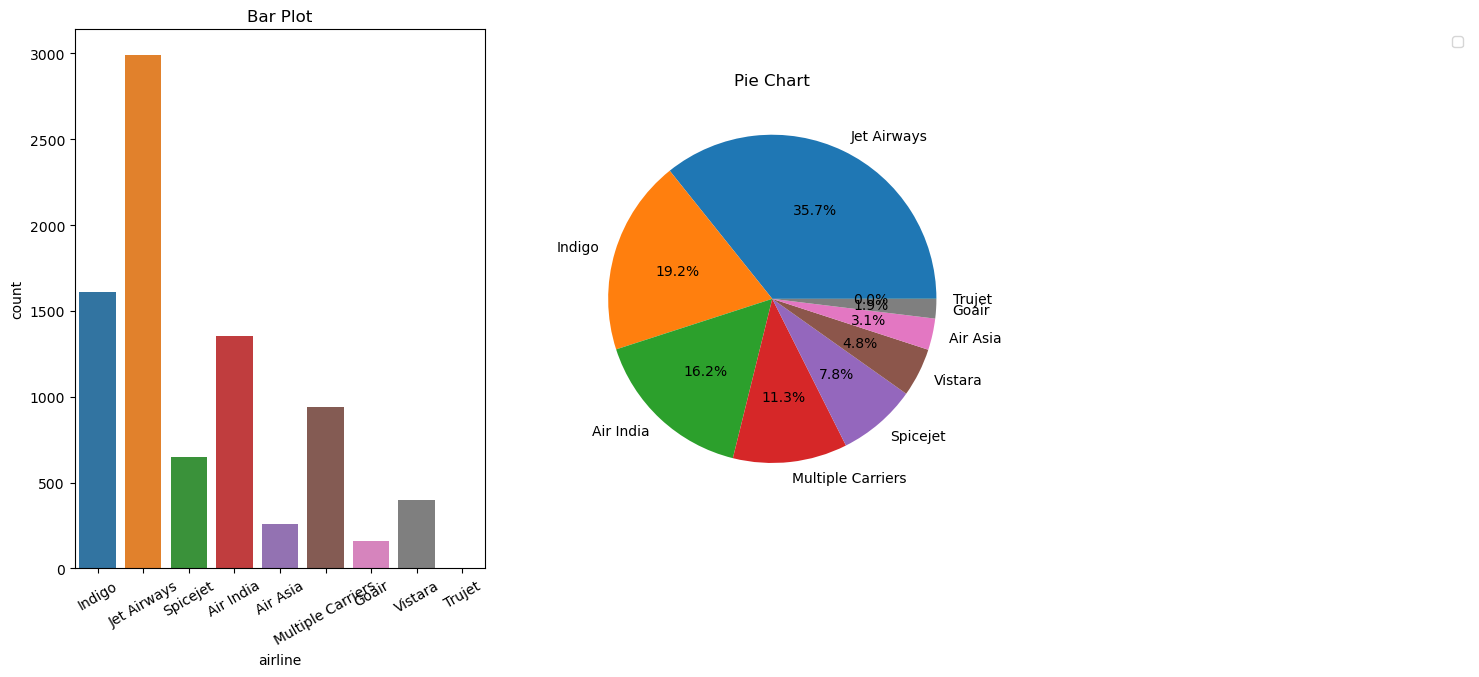

In [351]:
cat_univariate_plot(train,'airline',sh_wordcloud=False)

In [346]:

colors = [tuple(np.random.choice(256, size=3) / 255) for _ in range(len(counts))]
tuple(np.random.choice(256, size=3) / 255)

(0.8862745098039215, 0.9176470588235294, 0.6627450980392157)

In [343]:
counts = (
        train
        .loc[:, 'airline']
        .value_counts()
    )
counts

Jet Airways          2991
Indigo               1610
Air India            1352
Multiple Carriers     943
Spicejet              651
Vistara               401
Air Asia              259
Goair                 160
Trujet                  1
Name: airline, dtype: int64

In [458]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import stats
import statsmodels.api as sm
from sklearn.preprocessing import (
    PowerTransformer,
    OneHotEncoder,
    StandardScaler
)
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from wordcloud import WordCloud, STOPWORDS
from IPython.display import display, HTML

In [368]:
def display_html(size=3, content="content"):
    display(HTML(f"<h{size}>{content}</h{size}>"))

In [764]:
def rotate_xlabels(ax,angle=35):
     ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=35,
        ha='right')
def rotate_ylabels(ax, angle=0):
  ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=angle
  )

#Pair Grid
def plot_pairGrid(data,height=3,aspect_ratio=1.5,
    corner=True,hue=None,legend=False):
    display_html(2, "Pair Plots")
    pair_grid=sns.PairGrid(data=data,hue=hue,aspect_ratio=aspect_ratio,
                height=height,corner=True)
    pair_grid.map_upper(sns.scatterplot)
    pair_grid.map_lower(sns.kdeplot)
    pair_grid.map_diag(sns.kdeplot)
    
    
    if legend:
        pair_grid.add_legend()
        
        
#correlation matrix
def correlation_heatmap(
    data,
    figsize=(12,6),
    method='spearman',
    cmap='RdBu'):
    
    cm=data.corr(
        method=method,
        numeric_only=True)
    
    mask = np.zeros_like(cm, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    fig, ax = plt.subplots(figsize=figsize)
    hm = sns.heatmap(
      cm,
      vmin=-1,
      vmax=1,
      cmap=cmap,
      center=0,
      annot=True,
      fmt=".2f",
      linewidths=1.5,
      square=True,
      mask=mask,
      ax=ax)
    rotate_xlabels(ax)
    rotate_ylabels(ax)
    ax.set(title=f"{method.title()} Correlation Matrix Heatmap")
    

# gives detailed summary of numeric features
def num_summary(data, var):
    import warnings
    warnings.filterwarnings("ignore")

  # title
    col = data.loc[:, var].copy()
    display_html(size=2, content=var)

  # quick glance
    display_html(3, "Quick Glance:")
    display(col)

  # meta-data
    display_html(3, "Meta-data:")
    print(f"{'Data Type':15}: {col.dtype}")
    print(f"{'Missing Data':15}: {col.isna().sum():,} rows ({col.isna().mean() * 100:.2f} %)")
    print(f"{'Available Data':15}: {col.count():,} / {len(col):,} rows")
    

  # percentiles
    display_html(3,"Percentiles")
    display(data
    .duration
    .quantile([0.0,0.05,0.1,0.25,0.5,0.75,0.9,0.95,1.0])
    .rename(index=lambda val:f"{val*100}")
    .rename('value')
    .rename_axis('percentiles')
    .to_frame()
    )
    
    
    # central tendancy
    display_html(3,"Central Tendancy")
    display(
      pd
      .Series({"mean": col.mean(),
               "trimmed mean (5%)": stats.trim_mean(col.values, 0.05),
               "trimmed mean (10%)": stats.trim_mean(col.values, 0.1),
               "median": col.median()})
      .rename("value")
      .to_frame())
    
    
    # spread
    display_html(3, "Measure of Spread:")
    std = col.std()
    iqr = col.quantile(0.75) - col.quantile(0.25)
    display(
      pd
      .Series({
          "var": col.var(),
          "std": std,
          "IQR": iqr,
          "mad": stats.median_abs_deviation(col.dropna()),
          "coef_variance": std / col.mean()
      })
      .rename("value")
      .to_frame())
    
    
     # skewness and kurtosis
    display_html(3, "Skewness and Kurtosis:")
    display(
      pd
      .Series({
          "skewness": col.skew(),
          "kurtosis": col.kurtosis()
      })
      .rename("value")
      .to_frame())
    
    
    alpha = 0.05
  # test for normality
    display_html(3, "Hypothesis Testing for Normality:")
  # shapiro-wilk test
    display_html(4, "Shapiro-Wilk Test:")
    sw_test = stats.shapiro(col.dropna().values)
    sw_statistic = sw_test.statistic
    sw_pvalue = sw_test.pvalue
    print(f"{'Significance Level':21}: {alpha}")
    print(f"{'Null Hypothesis':21}: The data is normally distributed")
    print(f"{'Alternate Hypothesis':21}: The data is not normally distributed")
    print(f"{'p-value':21}: {sw_pvalue}")
    print(f"{'Test Statistic':21}: {sw_statistic}")
    if sw_pvalue < alpha:
        print(f"- Since p-value is less than alpha ({alpha}), we Reject the Null Hypothesis at {alpha * 100}% significance level")
        print("- CONCLUSION: We conclude that the data sample is not normally distributed")
    else:
        print(f"- Since p-value is greater than alpha ({alpha}), we Fail to Reject the Null Hypothesis at {alpha * 100}% significance level")
        print("- CONCLUSION: We conclude that the data sample is normally distributed")
    
    
     #anderson-darling test
    display_html(4, "Anderson-Darling Test:")
    ad_test = stats.anderson(col.dropna().values, dist="norm")
    ad_statistic = ad_test.statistic
    ad_critical = ad_test.critical_values[2]
    print(f"{'Significance Level':21}: {alpha}")
    print(f"{'Null Hypothesis':21}: The data is normally distributed")
    print(f"{'Alternate Hypothesis':21}: The data is not normally distributed")
    print(f"{'Critical Value':21}: {ad_critical}")
    print(f"{'Test Statistic':21}: {ad_statistic}")
    if ad_statistic >= ad_critical:
        print(f"- Since the Test-statistic is greater than Critical Value, we Reject the Null Hypothesis at {alpha * 100}% significance level")
        print("- CONCLUSION: We conclude that the data sample is not normally distributed")
    else:
        print(f"- Since the Test-statistic is less than Critical Value, we Fail to Reject the Null Hypothesis at {alpha * 100}% significance level")
        print("- CONCLUSION: We conclude that the data sample is normally distributed")
        
    # hypothesis testing for association between 2 numeric variables
def num_num_hyp_testing(data, var1, var2, alpha=0.05):
    display_html(2, f"Hypothesis Test for Association between {var1} and {var2}")

    temp = (
      data
      .dropna(subset=[var1, var2], how="any")
      .copy())

  # pearson test
    pearson = stats.pearsonr(temp[var1].values, temp[var2].values)
    pvalue = pearson.pvalue
    statistic = pearson.statistic
    display_html(3, "Pearson Test")
    print(f"- {'Significance Level':21}: {alpha * 100}%")
    print(f"- {'Null Hypothesis':21}: The samples are uncorrelated")
    print(f"- {'Alternate Hypothesis':21}: The samples are correlated")
    print(f"- {'Test Statistic':21}: {statistic}")
    print(f"- {'p-value':21}: {pvalue}")
    if pvalue < alpha:
        print(f"- Since p-value is less than {alpha}, we Reject the Null Hypothesis at {alpha * 100}% significance level")
        print(f"- CONCLUSION: The variables {var1} and {var2} are correlated")
    else:
        print(f"- Since p-value is greater than {alpha}, we Fail to Reject the Null Hypothesis at {alpha * 100}% significance level")
        print(f"- CONCLUSION: The variables {var1} and {var2} are uncorrelated")

  # spearman test
    spearman = stats.spearmanr(temp[var1].values, temp[var2].values)
    pvalue = spearman.pvalue
    statistic = spearman.statistic
    display_html(3, "Spearman Test")
    print(f"- {'Significance Level':21}: {alpha * 100}%")
    print(f"- {'Null Hypothesis':21}: The samples are uncorrelated")
    print(f"- {'Alternate Hypothesis':21}: The samples are correlated")
    print(f"- {'Test Statistic':21}: {statistic}")
    print(f"- {'p-value':21}: {pvalue}")
    if pvalue < alpha:
        print(f"- Since p-value is less than {alpha}, we Reject the Null Hypothesis at {alpha * 100}% significance level")
        print(f"- CONCLUSION: The variables {var1} and {var2} are correlated")
    else:
        print(f"- Since p-value is greater than {alpha}, we Fail to Reject the Null Hypothesis at {alpha * 100}% significance level")
        print(f"- CONCLUSION: The variables {var1} and {var2} are uncorrelated")

# univariate plots for numeric variables
def num_univar_plots(data, var, bins=10, figsize=(15, 7)):
    display_html(2, f"Univariate Analysis of {var}")
    display_html(content="")
    col = data.loc[:, var].copy()

    fig, axes = plt.subplots(2, 3, figsize=figsize)
    axes = axes.ravel()

    #histogram
    sns.histplot(
      data,
      x=var,
      bins=bins,
      kde=True,
      color="#1973bd",
      ax=axes[0],
      )
    sns.rugplot(
      data,
      x=var,
      color="black",
      height=0.035,
      ax=axes[0]
     )
    axes[0].set(title="Histogram")

  # cdf
    sns.ecdfplot(
    data,
    x=var,
    ax=axes[1],
    color="red")
    axes[1].set(title="CDF")

  # power transform
    data = data.assign(**{
       f"{var}_pwt": (
          PowerTransformer()
          .fit_transform(data.loc[:, [var]])
          .ravel())
     })
    
    sns.kdeplot(
      data,
      x=f"{var}_pwt",
      fill=True,
      color="#f2b02c",
      ax=axes[2])
        
    sns.rugplot(
      data,
      x=f"{var}_pwt",
      color="black",
      height=0.035,
      ax=axes[2])
    
    axes[2].set(title="Power Transformed")

  # box plot
    sns.boxplot(
      data,
      x=var,
      color="#4cd138",
      ax=axes[3])
    axes[3].set(title="Box Plot")

  # violin plot
    sns.violinplot(
      data,
      x=var,
      color="#ed68b4",
      ax=axes[4])
    axes[4].set(title="Violin Plot")

  # qq plot
    sm.qqplot(
      col.dropna(),
      line="45",
      fit=True,
      ax=axes[5])
    axes[5].set(title="QQ Plot")

    plt.tight_layout()
    plt.show()

    
# bivariate plots between 2 numeric variables
def num_bivar_plots(data, var_x, var_y, figsize=(12, 4.5), scatter_kwargs=dict(), hexbin_kwargs=dict()):
    display_html(2, f"Bi-variate Analysis between {var_x} and {var_y}")
    display_html(content="")

    fig, axes = plt.subplots(1, 2, figsize=figsize)

  # scatter plot
    sns.scatterplot(
      data,
      x=var_x,
      y=var_y,
      ax=axes[0],
      edgecolor="black",
      **scatter_kwargs)
    
    axes[0].set(title="Scatter Plot")

  # hexbin plot
    col_x = data.loc[:, var_x]
    col_y = data.loc[:, var_y]
    
    hexbin = axes[1].hexbin(
      x=col_x,
      y=col_y,
      **hexbin_kwargs)
    
    axes[1].set(
      title="Hexbin Plot",
      xlabel=var_x,
      xlim=(col_x.min(), col_x.max()),
      ylim=(col_y.min(), col_y.max()))
    
    cb = plt.colorbar(
      hexbin,
      label="Count")

    plt.tight_layout()
    plt.show()
    

# gives detailed summary of categorical features
def cat_summary(data, var):
    import warnings
    warnings.filterwarnings("ignore")

  # title
    col = data.loc[:, var].copy()
    display_html(2, var)

  # quick glance
    display_html(3, "Quick Glance:")
    display(col)

  # meta-data
    display_html(3, "Meta-data:")
    print(f"{'Data Type':15}: {col.dtype}")
    print(f"{'Cardinality':15}: {col.nunique(dropna=True)} categories")
    print(f"{'Missing Data':15}: {col.isna().sum():,} rows ({col.isna().mean() * 100:.2f} %)")
    print(f"{'Available Data':15}: {col.count():,} / {len(col):,} rows")

  # summary
    display_html(3, "Summary:")
    display(
      col
      .describe()
      .rename("")
      .to_frame())

  # categories
    display_html(3, "Categories Distribution:")
    with pd.option_context("display.max_rows", None):
        display(
        col
        .value_counts()
        .pipe(lambda ser: pd.concat(
            [
                ser,
                col.value_counts(normalize=True)
            ],
            axis=1
        ))
        .set_axis(["count", "percentage"], axis=1)
        .rename_axis(index="category"))
    

# hypothesis testing for association between numeric and categorical variable
def num_cat_hyp_testing(data, num_var, cat_var, alpha=0.05):
    display_html(2, f"Hypothesis Test for Association between {num_var} and {cat_var}")

    groups_df = (
      data
      .dropna(subset=[num_var])
      .groupby(cat_var))
    groups = [group[num_var].values for _, group in groups_df]

  # anova test
    anova = stats.f_oneway(*groups)
    statistic = anova[0]
    pvalue = anova[1]
    display_html(3, "ANOVA Test")
    print(f"- {'Significance Level':21}: {alpha * 100}%")
    print(f"- {'Null Hypothesis':21}: The groups have similar population mean")
    print(f"- {'Alternate Hypothesis':21}: The groups don't have similar population mean")
    print(f"- {'Test Statistic':21}: {statistic}")
    print(f"- {'p-value':21}: {pvalue}")
    if pvalue < alpha:
        print(f"- Since p-value is less than {alpha}, we Reject the Null Hypothesis at {alpha * 100}% significance level")
        print(f"- CONCLUSION: The variables {num_var} and {cat_var} are associated to each other")
    else:
        print(f"- Since p-value is greater than {alpha}, we Fail to Reject the Null Hypothesis at {alpha * 100}% significance level")
        print(f"- CONCLUSION: The variables {num_var} and {cat_var} are not associated to each other")

  # kruskal-wallis test
    kruskal = stats.kruskal(*groups)
    statistic = kruskal[0]
    pvalue = kruskal[1]
    display_html(3, "Kruskal-Wallis Test")
    print(f"- {'Significance Level':21}: {alpha * 100}%")
    print(f"- {'Null Hypothesis':21}: The groups have similar population median")
    print(f"- {'Alternate Hypothesis':21}: The groups don't have similar population median")
    print(f"- {'Test Statistic':21}: {statistic}")
    print(f"- {'p-value':21}: {pvalue}")
    if pvalue < alpha:
        print(f"- Since p-value is less than {alpha}, we Reject the Null Hypothesis at {alpha * 100}% significance level")
        print(f"- CONCLUSION: The variables {num_var} and {cat_var} are associated to each other")
    else:
        print(f"- Since p-value is greater than {alpha}, we Fail to Reject the Null Hypothesis at {alpha * 100}% significance level")
        print(f"- CONCLUSION: The variables {num_var} and {cat_var} are not associated to each other")
        

#univariate plots for categorical variables
#helper functions
def get_top_k(data, var, k):
    col = data.loc[:, var].copy()
    cardinality = col.nunique(dropna=True)
    if k >= cardinality:
        raise ValueError(f"Cardinality of {var} is {cardinality}. K must be less than {cardinality}.")
    else:
        top_categories = (
        col
        .value_counts(dropna=True)
        .index[:k])
        
        data = data.assign(**{
        var: np.where(
            col.isin(top_categories),
            col,
            "Other")
        })
    return data

def pie_chart(counts, colors, ax):
    pie = ax.pie(
        counts.values,
        labels=counts.index,
        autopct="%.2f%%",
        colors=colors,
        wedgeprops=dict(alpha=0.7, edgecolor="black"), )

    ax.set_title("Pie Chart")

    ax.legend(
      loc="upper left",
      bbox_to_anchor=(1.02, 1),
      title="Categories",
      title_fontproperties=dict(weight="bold", size=10) )

    plt.setp(
      pie[2],
      weight="bold",
      color="white"
  )


def bar_chart(counts, colors, ax):
    barplot = ax.bar(
        x=range(len(counts)),
        height=counts.values,
        tick_label=counts.index,
        color=colors,
        edgecolor="black",
        alpha=0.7)

    ax.bar_label(
      barplot,
      padding=5,
      color="black")

    ax.set(
      title="Bar Chart",
      xlabel="Categories",
      ylabel="Count")

    ax.set_xticklabels(
      ax.get_xticklabels(),
      rotation=45,
      ha="right")


    ax.set_xticklabels(
      ax.get_xticklabels(),
      rotation=45,
      ha="right"
  )


def cat_univar_plots(data,
                     var,
                     k=None,
                     order=None,
                     show_wordcloud=True,
                     figsize=(12, 8.5)
                     ):
    display_html(2, f"Univariate Analysis of {var}")
    display_html(content="")

    fig = plt.figure(figsize=figsize)
    gs = GridSpec(2, 2, figure=fig)
    ax1 = fig.add_subplot(gs[0, 0]) # bar-chart
    ax2 = fig.add_subplot(gs[0, 1]) # pie-chart
    ax3 = fig.add_subplot(gs[1, :]) # word-cloud
    

    if k is None:
        counts = (
        data
        .loc[:, var]
        .value_counts()
        .reindex(index=order))
    else:
        temp = get_top_k(
        data,
        var,
        k=k)
        
        counts = (
         temp
        .loc[:, var]
        .value_counts())

    colors = [tuple(np.random.choice(256, size=3) / 255) for _ in range(len(counts))]

  # bar-chart
    bar_chart(
      counts,
      colors,
      ax1)

  # pie_chart
    pie_chart(
      counts,
      colors,
      ax2)

  # word-cloud
    if show_wordcloud:
        var_string = " ".join(
         data
        .loc[:, var]
        .dropna()
        .str.replace(" ", "_")
        .to_list())

        word_cloud = WordCloud(
        width=2000,
        height=700,
        random_state=42,
        background_color="black",
        colormap="Set2",
        stopwords=STOPWORDS).generate(var_string)

        ax3.imshow(word_cloud)
        ax3.axis("off")
        ax3.set_title("Word Cloud")
    else:
        ax3.remove()

    plt.tight_layout()
    plt.show()
    
    

# categorical bivariate plots
def cat_heat_map(data, mask=True, **kwargs):
    if mask:
        mask = np.zeros_like(data, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
    else:
        mask = None

    return sns.heatmap(
      data=data,
      mask=mask,
      annot=True,
      linewidths=1.5,
      linecolor="white",
      square=True,
      **kwargs)

# bivariate analysis between 2 categorical variables
def cat_bivar_plots(data,
                    var1,
                    var2,
                    k1=None,
                    k2=None,
                    order1=None,
                    order2=None,
                    figsize=(12, 8.5)):

    import warnings
    warnings.filterwarnings("ignore")

    display_html(2, f"Bi-variate Analysis between {var1} and {var2}")
    display_html(content="")

    if k1 is not None:
        data = get_top_k(
        data,
        var1,
        k=k1)

    if k2 is not None:
        data = get_top_k(
        data,
        var2,
        k=k2)

    fig, axes = plt.subplots(2, 2, figsize=figsize)
    axes = axes.ravel()

  # cross-tab heatmap
    ct = (
      pd
      .crosstab(
          index=data.loc[:, var1],
          columns=data.loc[:, var2]
      )
      .reindex(
          index=order1,
          columns=order2
      ))
    hm = cat_heat_map(
      ct,
      mask=False,
      vmin=ct.values.min(),
      vmax=ct.values.max(),
      fmt="d",
      cmap="Blues",
      cbar_kws=dict(location="top", label="Counts"),
      ax=axes[0])
    
    rotate_ylabels(axes[0])
    rotate_xlabels(axes[0])

  # normalized cross-tab heatmap
    norm_ct = (
      pd
      .crosstab(
          index=data.loc[:, var1],
          columns=data.loc[:, var2],
          normalize="index"
      )
      .reindex(
          index=order1,
          columns=order2
      )
  )
    norm_hm = cat_heat_map(
      norm_ct,
      mask=False,
      vmin=0,
      vmax=1,
      fmt=".2f",
      cmap="Greens",
      cbar_kws=dict(location="top", label="Normalized"),
      ax=axes[1])
    
    axes[1].set(ylabel="")
    rotate_ylabels(axes[1])
    rotate_xlabels(axes[1])

  # bar plot
    (ct
    .plot
    .bar(
     ax=axes[2],
    title="Bar Plot",
    legend=False))
    rotate_xlabels(axes[2])

  # stacked bar plot
    (norm_ct
      .plot
      .bar(
       ax=axes[3],
       title="Stacked Bar Plot",
       stacked=True))
    
    rotate_xlabels(axes[3])
    axes[3].legend(
      loc="upper left",
      bbox_to_anchor=(1, 1),
      title=var2)

    plt.tight_layout()
    plt.show()

# cramers-v corrrelation heatmap
def cramers_v(data, var1, var2):
    cm=pd.crosstab(data.loc[:,var1],
               data.loc[:,var2])
    chi=stats.chi2_contingency(cm).statistic
    r,c=cm.shape
    n=cm.sum().sum()
    pchi=chi/n

    # bias correction
    phi2_=max(0,pchi,(-(((r-1)*(c-1))/(n-1))))
    r_ = r - (((r - 1) ** 2) / (n - 1))
    c_ = c - (((c - 1) ** 2) / (n - 1))
    
    return np.sqrt(phi2_ / min(r_ - 1, c_ - 1))


# hypothesis testing between 2 categorical variables
def hyp_cat_cat(data, var1, var2, alpha=0.05):
    display_html(2, f"Hypothesis Test for Association between {var1} and {var2}")

    ct = pd.crosstab(
      data.loc[:, var1],
      data.loc[:, var2])

    display_html(3, "Chi-square Test")
    chi2 = stats.chi2_contingency(ct)
    statistic = chi2.statistic
    pvalue = chi2.pvalue
    print(f"- {'Cramers V':21}: {cramers_v(data, var1, var2)}")
    print(f"- {'Significance Level':21}: {alpha * 100}%")
    print(f"- {'Null Hypothesis':21}: The samples are uncorrelated")
    print(f"- {'Alternate Hypothesis':21}: The samples are correlated")
    print(f"- {'Test Statistic':21}: {statistic}")
    print(f"- {'p-value':21}: {pvalue}")
    if pvalue < alpha:
        print(f"- Since p-value is less than {alpha}, we Reject the Null Hypothesis at {alpha * 100}% significance level")
        print(f"- CONCLUSION: The variables {var1} and {var2} are correlated")
    else:
        print(f"- Since p-value is greater than {alpha}, we Fail to Reject the Null Hypothesis at {alpha * 100}% significance level")
        print(f"- CONCLUSION: The variables {var1} and {var2} are uncorrelated")

# missing values
def missing_info(data):
    na_cols = [col for col in data.columns if data[col].isna().any()]
    na_counts = [data[col].isna().sum() for col in na_cols]
    na_pct = [(data[col].isna().mean() * 100) for col in na_cols]

    return (
      pd
      .DataFrame(data={
          "variable": na_cols,
          "count": na_counts,
          "percentage": na_pct
      })
      .sort_values(by="count", ascending=False)
      .set_index("variable")
  )

def plot_missing_info(data, bar_label_params=dict(), figsize=(10, 4)):
    na_data = missing_info(data)
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    bar = ax.bar(
      range(len(na_data)),
      height=na_data["count"].values,
      color="#1eba47",
      edgecolor="black",
      tick_label=na_data.index.to_list(),
      alpha=0.7)
    
    ax.bar_label(
      bar,
      **bar_label_params)
    
    ax.set(
      xlabel="Variable",
      ylabel="Count",
      title="Missing Data Counts per Variable")
    
    rotate_xlabels(ax)
    plt.tight_layout()
    plt.show()


# iqr outliers
def get_iqr_outliers(data, var, band=1.5):
    q1, q3 = (
      data
      .loc[:, var]
      .quantile([0.25, 0.75])
      .values
    )

    iqr = q3 - q1
    lower_limit = q1 - (band * iqr)
    upper_limit = q3 + (band * iqr)

    display_html(3, f"{var} - IQR Limits:")
    print(f"{'Lower Limit':12}: {lower_limit}")
    print(f"{'Upper Limit':12}: {upper_limit}")

    return (
      data
      .query(f"{var} > @upper_limit | {var} < @lower_limit")
      .sort_values(var)
    )


# univariate plots for date-time variables
def dt_univar_plots(data, var, target=None, bins="auto"):
    display_html(3, f"Univariate plots of {var}")
    col = data.loc[:, var].copy()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

  # histogram
    sns.histplot(
    data=data,
    x=var,
    bins=bins,
    color="#1973bd",
    ax=ax1)
    
    sns.rugplot(
    data=data,
    x=var,
    color="darkblue",
    height=0.035,
    ax=ax1)
    
    ax1.set(title="Histogram")
    rotate_xlabels(ax1)

  # line-plot
    sns.lineplot(
    data=data,
    x=var,
    y=target,
    color="#d92b2b",
    ax=ax2)
    
    
    ax2.set(title="Line Plot")
    rotate_xlabels(ax2)
    
# bivariate plots between numeric and categorical variable

def num_cat_bivar_plots(data,
num_var,
cat_var,
k=None,
estimator="mean",
orient="v",
order=None,
figsize=(15, 4)):

    def get_values(data,
                 num_var,
                 cat_var,
                 estimator,
                 order=None):

        return (
        data
        .groupby(cat_var)
        .agg(estimator, numeric_only=True)
        .loc[:, num_var]
        .dropna()
        .sort_values()
        .reindex(index=order))

        import warnings
        warnings.filterwarnings("ignore")

        display_html(2, f"Bi-variate Analysis between {cat_var} and {num_var}")
        display_html(content="")

        if k is None:
            temp = get_values(
            data,
            num_var,
            cat_var,
            estimator,
            order=order)
        else:
            data = get_top_k(
            data,
            cat_var,
            k=k)

        temp = get_values(
        data,
        num_var,
        cat_var,
        estimator)

        if orient == "v":
            fig, axes = plt.subplots(1, 3, figsize=figsize)

    # bar plot
            bar = sns.barplot(
            x=temp.index,
            y=temp.values,
            color="#d92b2b",
            ax=axes[0],
            edgecolor="black",
            alpha=0.5)

            axes[0].set(
            title="Bar Plot",
            xlabel=cat_var,
            ylabel=num_var)

            rotate_xlabels(axes[0])

    # box plot
            sns.boxplot(
            data,
            x=cat_var,
            y=num_var,
            color="lightgreen",
            order=temp.index,
            ax=axes[1])

            axes[1].set(
            title="Box Plot",
            xlabel=cat_var,
            ylabel="")

            rotate_xlabels(axes[1])

    # violin plot
            sns.violinplot(
            data,
            x=cat_var,
            y=num_var,
            color="#0630c9",
            order=temp.index,
            ax=axes[2],
            alpha=0.5)

            axes[2].set(
            title="Violin Plot",
            xlabel=cat_var,
            ylabel="")

            rotate_xlabels(axes[2])

        else:
            fig, axes = plt.subplots(3, 1, figsize=figsize)

    # bar plot
    bar = sns.barplot(
      y=temp.index,
      x=temp.values,
      color="#d92b2b",
      ax=axes[0],
      edgecolor="black",
      alpha=0.5
    )
    axes[0].set(
        title="Bar Plot",
        xlabel="",
        ylabel=cat_var
    )

    # box plot
    sns.boxplot(
      data,
      y=cat_var,
      x=num_var,
      color="lightgreen",
      order=temp.index,
      ax=axes[1]
    )
    axes[1].set(
        title="Box Plot",
        xlabel="",
        ylabel=cat_var
    )

    # violin plot
    sns.violinplot(
      data,
      y=cat_var,
      x=num_var,
      color="#0630c9",
      order=temp.index,
      ax=axes[2],
      alpha=0.5)

    axes[2].set(
        title="Violin Plot",
        xlabel=num_var,
        ylabel=cat_var )

    plt.tight_layout()
    plt.show()



In [765]:
train.columns

Index(['airline', 'date_of_journey', 'source', 'destination', 'dep_time',
       'arrival_time', 'duration', 'total_stops', 'additional_info', 'price'],
      dtype='object')

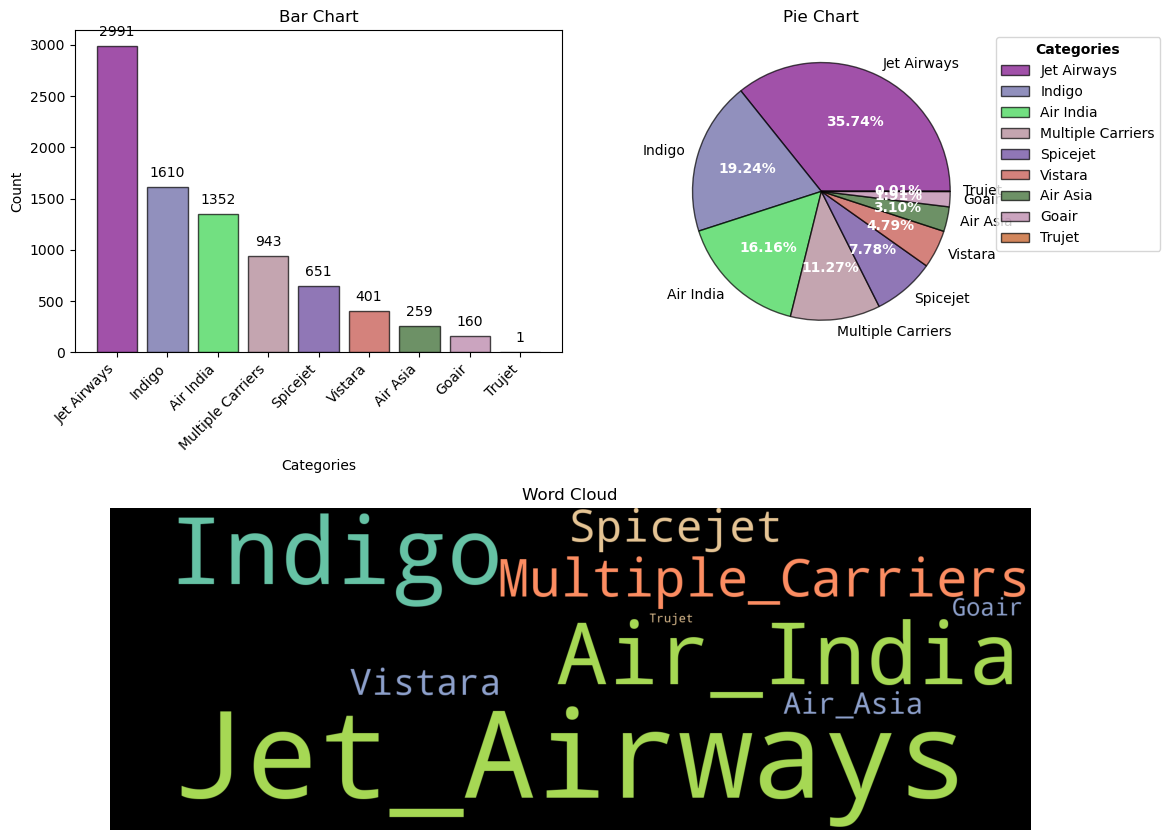

In [768]:

cat_univar_plots(train,'airline',show_wordcloud=True)